## Importing and Cleaning

#### Running all the videos - classifying objects - and pickle object_id of vehicles and pedestrains

In [1]:
def classify(max_objects, df_positions):
    veh_id=[]
    ped_id=[]
    for i in range(max_objects):
        temp=df_positions.loc[df_positions['object_id'] == i].reset_index(drop=True)
        

        x_diff = (temp['x_coordinate'][temp.shape[0]-1]-temp['x_coordinate'][0])
        y_diff = (temp['y_coordinate'][temp.shape[0]-1]-temp['y_coordinate'][0])

    #If you want to print the differences for every object, uncomment the two lines below    
    # =============================================================================
    #     print('Diff in X for '+ str(i) + ' is ' +str(x_diff))
    #     print('Diff in Y for '+ str(i) + ' is ' +str(y_diff))
    #     print('\n\n')
    # =============================================================================


        if abs(x_diff) > 15:
            veh_id.append(i)
        elif abs(y_diff) > 2:
            ped_id.append(i)
        
    return veh_id, ped_id

#x,y=classify(max_objects, df_positions)
#print x,y

In [2]:
def SQL_to_Pandas(filename):
    #=============================================================
    ## COMMENT TO PROCESS ALL THE DATABASES
    #=============================================================
    con = sqlite3.connect(path+filename)

    #Defining The number of objects we have
    sql_command = "SELECT COUNT(*) FROM objects"

    max_objects_sql = con.execute(sql_command)
    max_objects = max_objects_sql.fetchone()
    max_objects=max_objects[0]

    ## Using the SQL command
    # Getting the positions of every object
    df_positions = pd.read_sql_query("SELECT a.object_id,  b.frame_number, x_coordinate, y_coordinate\
    FROM objects_features AS a \
    JOIN positions AS b ON a.trajectory_id = b.trajectory_id",con)

    # Getting the velocities of every object
    df_velocities = pd.read_sql_query("SELECT a.object_id,  b.frame_number, b.x_coordinate, b.y_coordinate\
    FROM objects_features AS a \
    JOIN velocities AS b ON a.trajectory_id = b.trajectory_id",con)


    # Merging the velocities and positions
    df = pd.DataFrame()

    df=df_positions.copy()
    df['v_x']=df_velocities['x_coordinate']
    df['v_y']=df_velocities['y_coordinate']
    df.columns = ['object', 'frame', 'x', 'y', 'v_x', 'v_y']
    
    #=============================================================
    # UNCOMMENT IF YOU WOULD LIKE TO COMPUTE THE AVERAGE OVER THE TRAJECTORIES

    #df=df.groupby(['object','frame']).mean().reset_index()

    
    return df, df_positions, max_objects

In [3]:
import sqlite3
from pandas.io.sql import read_sql
from sqlalchemy import create_engine
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Get files from directory:
import os
import timeit
#=============================================================
## -------- ADD PATH TO THE SQLITE FILE!!! ------------------
path = 'C:\\Users\\admin\\Desktop\\Capstone\\Final SQL\\0206_1218\\'

#for loop to go over all the databases
for filename in os.listdir(path):

    
    [df, df_positions, max_objects]=SQL_to_Pandas(filename)
    #=============================================================
    ## UNCOMMENT TO PLOT
    for i in range(max_objects):

        X0=pd.Series.tolist((df.loc[df['object'] == i])['x'])
        Y0=pd.Series.tolist((df.loc[df['object'] == i])['y'])
        plt.scatter(X0,Y0)
        plt.xlabel("X positions")
        plt.ylabel("Y positions")
        plt.title("Trajectories of moving objects of"+ filename)
    #plt.show()
    #=============================================================

    ## --------------- Classification  --------------------------

    veh_id,ped_id=classify(max_objects,df_positions)


    #=============================================================
    ## UNCOMMENT TO SEE THE VEHICLES AND PEDESTRIANS ID

    #print veh_id,ped_id
    
    len_max=max(len(veh_id), len(ped_id))
    veh_id_bis=[-1 for i in range(len_max)]
    ped_id_bis=[-1 for i in range(len_max)]
    for i in range(len(veh_id)):
        veh_id_bis[i]=veh_id[i]
    for i in range(len(ped_id)):
        ped_id_bis[i]=ped_id[i]
    #print veh_id_bis, ped_id_bis
    #============================================================= 

    pairing = {'veh_id': veh_id_bis, 'ped_id': ped_id_bis}
    #df_pairing = pd.DataFrame(data=pairing)
    #df_pairing.to_pickle("obj_ID_"+filename)


## Pairing output

In [6]:
inter=pd.read_csv('pairs_0206_1228A.csv')
inter=inter.drop(['Unnamed: 0'], axis=1)
i='clip_2'
print i
inter.loc[inter['clip'] == i]['veh_id'][1]
inter.loc[inter['clip'] == i]['ped_id'][1]
inter

clip_2


,clip,ped_id,veh_id
0,clip_1,8,14
1,clip_2,28,23
2,clip_3,23,7
3,clip_4,15,10
4,clip_6,35,34
5,clip_7,32,17
6,clip_8,8,3
7,clip_8,8,7
8,clip_8,8,22
9,clip_8,25,22


In [11]:
## Left as the how because we take the pedestrian as a base

for i in inter['clip']:
    k=0
    if i!='clip_8' and  i!='clip_12' and  i!='clip_13' and  i!='clip_14':

        [df, df_positions, max_objects]=SQL_to_Pandas(i+'.sqlite')
        #print int(inter.loc[inter['clip'] == i]['veh_id'].values)

        veh_iden=int(inter.loc[inter['clip'] == i]['veh_id'].values)
        ped_iden=int(inter.loc[inter['clip'] == i]['ped_id'].values)

        vehicle=df.loc[df['object'] == veh_iden]    
        pedestrian=df.loc[df['object'] == ped_iden]

        interaction = pd.merge(vehicle, pedestrian, how ='inner', on = ['frame'])
        #print interaction
        interaction.columns = ['object1', 'frame', 'x1', 'y1', 'v_x1', 'v_y1', 'object2', 'x2', 'y2', 'v_x2', 'v_y2']
        if k==0:
            all_interactions=interaction.copy()
        else:
            frames = [all_interactions, interaction]
            all_interactions = pd.concat(frames)
    k=k+1
print all_interactions.shape

(14538, 11)


In [12]:
# calculate relative 
MLInput = pd.DataFrame()
MLInput['frame'] = all_interactions['frame']
MLInput['relative_X'] = all_interactions['x1'] - all_interactions['x2']
MLInput['relative_Y'] = all_interactions['y1'] - all_interactions['y2']
MLInput['relative_Vx'] = all_interactions['v_x1'] - all_interactions['v_x2']
MLInput['relative_Vy'] = all_interactions['v_y1'] - all_interactions['v_y2']
MLInput['brake'] = 0
#MLInput.columns = ['frame','relative_X','relative_Y','relative_Vx','relative_Vy','brake']


for frame in all_interactions['frame']:
    if len(all_interactions.loc[all_interactions['frame']==frame-1]['v_x1'].values)>0: 
        v_prev = all_interactions.loc[all_interactions['frame']==frame-1]['v_x1'].values[0]
        v = all_interactions.loc[all_interactions['frame']==frame]['v_x1'].values[0]
        if v - v_prev < 0:
            MLInput.loc[MLInput['frame']==frame,'brake'] = 1
        
MLInput.head()
MLInput.to_csv("Input1")

In [14]:
MLInput.head()

,frame,relative_X,relative_Y,relative_Vx,relative_Vy,brake
0,207,-5.018679,-1.041237,17.124257,0.004174,0
1,207,-5.295858,-0.906149,16.492421,1.912585,0
2,207,-5.351887,-0.872833,16.893308,1.308135,0
3,207,-5.040667,-0.801936,16.589175,1.795315,0
4,207,-4.965919,-0.867117,16.621133,1.785385,0


In [ ]:
#=============================================================
## -------- ADD PATH TO THE SQLITE FILE!!! ------------------
path = 'C:\\Users\\admin\\Desktop\\Capstone\\Final SQL\\0206_1218\\'

#for loop to go over all the databases
for filename in os.listdir(path):
    #=============================================================
    ## COMMENT TO PROCESS ALL THE DATABASES
    #if filename!='clip_5.sqlite':
    #=============================================================
        con = sqlite3.connect(path+filename)
        
        #Defining The number of objects we have
        sql_command = "SELECT COUNT(*) FROM objects"

        max_objects_sql = con.execute(sql_command)
        max_objects = max_objects_sql.fetchone()
        max_objects=max_objects[0]

        ## Using the SQL command
        # Getting the positions of every object
        df_positions = pd.read_sql_query("SELECT a.object_id,  b.frame_number, x_coordinate, y_coordinate\
        FROM objects_features AS a \
        JOIN positions AS b ON a.trajectory_id = b.trajectory_id",con)

        # Getting the velocities of every object
        df_velocities = pd.read_sql_query("SELECT a.object_id,  b.frame_number, b.x_coordinate, b.y_coordinate\
        FROM objects_features AS a \
        JOIN velocities AS b ON a.trajectory_id = b.trajectory_id",con)


        # Merging the velocities and positions
        df = pd.DataFrame()

        df=df_positions.copy()
        df['v_x']=df_velocities['x_coordinate']
        df['v_y']=df_velocities['y_coordinate']
        df.columns = ['object', 'frame', 'x', 'y', 'v_x', 'v_y']


In [ ]:
for i in veh_id:
    X0=pd.Series.tolist((df.loc[df['object'] == i])['x'])
    Y0=pd.Series.tolist((df.loc[df['object'] == i])['y'])
    plt.scatter(X0,Y0)
    plt.xlabel("X positions")
    plt.ylabel("Y positions")
    plt.title("Trajectories of moving objects of"+ filename)
for i in ped_id:
    X0=pd.Series.tolist((df.loc[df['object'] == i])['x'])
    Y0=pd.Series.tolist((df.loc[df['object'] == i])['y'])
    plt.scatter(X0,Y0)
    plt.xlabel("X positions")
    plt.ylabel("Y positions")
    plt.title("Trajectories of moving objects of"+ filename)
plt.show()


ped 10
veh 11


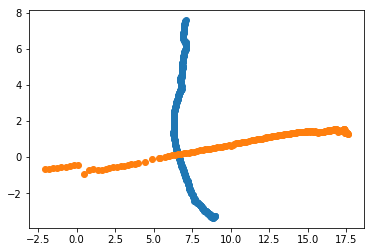

ped 15
veh 11


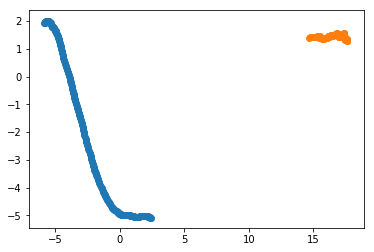

ped 10
veh 17


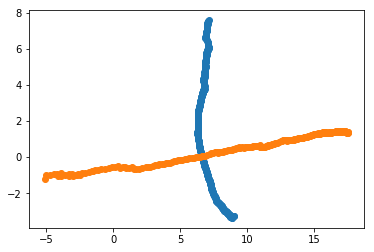

ped 15
veh 17


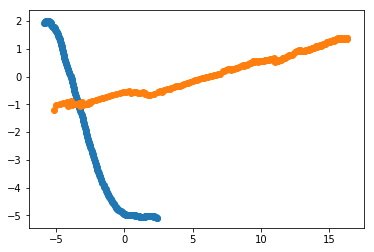

In [74]:
for i in veh_id:
    for j in ped_id:
        print 'ped', j
        print 'veh', i
        #We extract the ped and veh
        veh=df.loc[df['object'] == j]
        ped=df.loc[df['object'] == i]
        #print veh
        #print ped


        ## Left as the how because we take the pedestrian as a base
        interaction=pd.merge(veh, ped, how='left', on=['frame'])
        interaction.columns = ['object1', 'frame', 'x1', 'y1', 'v_x1', 'v_y1','object2', 'x2', 'y2', 'v_x2', 'v_y2']
        #print interaction

        #We get the interaction ! Let's plot it now
        X=pd.Series.tolist((interaction)['x1'])
        Y=pd.Series.tolist((interaction)['y1'])
        X2=pd.Series.tolist((interaction)['x2'])
        Y2=pd.Series.tolist((interaction)['y2'])
        plt.scatter(X,Y)
        plt.scatter(X2,Y2)
        plt.show()
